In [ ]:
import sys
import importlib
import os


# Chemin vers la racine du projet MCP
PROJECT_ROOT = os.path.abspath("../../")

os.chdir(PROJECT_ROOT)

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
    

# Supprimer l'ancien module du cache
if 'mcp_sentiment_server' in sys.modules:
    del sys.modules['mcp_sentiment_server']

# Importer à nouveau
from server.nlp.mcp_sentiment_server import analyze_sentiment

# OU utilisez importlib.reload
# import mcp_sentiment_server
# importlib.reload(mcp_sentiment_server)
# from mcp_sentiment_server import analyze_sentiment

import json
from collections import Counter


json_path = "data/articles_commentaires_final.json"
json_save_path = "data"

# Charger les données
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

item = data[-1]

#  ARTICLE 
article = item["article"]
article_text = str(article.get("contenu", ""))
article_author = article.get("auteur", "Inconnu")

print("=== ANALYSE DU POST ===")

post_result = analyze_sentiment({"text": article_text})

post_info = {
    "type": "article",
    "author": article_author,
    "content": article_text,
    "sentiment": post_result["sentiment"],
    "confidence": post_result["confidence"]
}

print(post_info)

#  COMMENTAIRES 
print("\n=== ANALYSE DES COMMENTAIRES ===")

results = []

for c in item["commentaires"]:
    content = str(c.get("content", ""))
    author = c.get("auteur", "Anonyme")

    if not content.strip():
        continue

    res = analyze_sentiment({"text": content})

    comment_info = {
        "type": "commentaire",
        "author": author,
        "content": content,
        "sentiment": res["sentiment"],
        "confidence": res["confidence"]
    }

    results.append(comment_info)
    print(comment_info)

#  DISTRIBUTION 
sentiments = [r["sentiment"] for r in results]
distribution = Counter(sentiments)

distribution_pct = {
    k: round(v / len(results), 3)
    for k, v in distribution.items()
}



#  EXPORT JSON 
output = {
    "post": post_info,
    "commentaires": results,
    "distribution": distribution_pct
}

with open(json_save_path + "/analyse_sentiments_result.json", "w", encoding="utf-8") as f:
    json.dump(output, f, ensure_ascii=False, indent=4)

print("\nRésultats enregistrés dans analyse_sentiments_result.json")

Le package server a été importé


The tokenizer you are loading from 'c:\Users\HP ZBOOK\Desktop\ETUDES\2024-2025\NLP\MCP\server\nlp\models\twitter-xlm-roberta' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


=== ANALYSE DU POST ===
{'type': 'article', 'author': 'Inconnu', 'content': "Les partis du groupe de l'appel du 09 avril ont été informés par voie de presse, le mardi 25 août 2015, de la décision du Conseil Constitutionnel relative à l'inéligibilité de certains de leurs membres aux élections couplées d'octobre 2015.Par cette décision, la preuve est encore faite que l'inclusion tant prônée dans la Charte de la transition n'est qu'un leurre. Elle consacre tout simplement l'exclusion des Partis de l'ex Front Républicain et alliés aux prochaines élections. Un tel acte s'interprète comme suit :1. La décision du Conseil Constitutionnel viole la loi parce qu'elle a été rendue hors délai légal au regard de l'article 96 du Code Electoral qui dispose que le conseil doit se prononcer dans les 8 jours de sa saisine après la clôture des délais.2. La décision du Conseil Constitutionnel viole la Constitution, en son article 95 qui dispose que le député ne peut pas être poursuivi, arrêté ou jugé pour 

In [2]:
print("\n=== DISTRIBUTION GLOBALE ===")
for k, v in distribution_pct.items():
    print(f"{k}: {v * 100:.1f}%")


=== DISTRIBUTION GLOBALE ===
negative: 88.8%
positive: 9.8%
neutral: 1.4%


In [3]:
import json

# Charger les résultats
with open(json_save_path + "/analyse_sentiments_result.json", "r", encoding="utf-8") as f:
    data = json.load(f)

commentaires = data["commentaires"]

# Séparer par sentiment
negative_comments = [c for c in commentaires if c['sentiment'] == 'negative']
positive_comments = [c for c in commentaires if c['sentiment'] == 'positive']
neutral_comments = [c for c in commentaires if c['sentiment'] == 'neutral']

# Fonction pour afficher les meilleurs commentaires
def display_top_comments(comments, sentiment_name, n=2):
    # Trier par confiance décroissante
    top = sorted(comments, key=lambda x: x['confidence'], reverse=True)[:n]
    
    print(f"\n{'='*80}")
    print(f"  TOP {n} COMMENTAIRES - {sentiment_name.upper()}")
    print(f"{'='*80}\n")
    
    for i, c in enumerate(top, 1):
        print(f"[{i}] Auteur: {c['author']}")
        print(f"    Sentiment: {c['sentiment']} | Confiance: {c['confidence']:.3f}")
        print(f"    Texte: {c['content'][:200]}{'...' if len(c['content']) > 200 else ''}")
        print()

# Afficher les tops
display_top_comments(negative_comments, "NÉGATIFS", n=2)
display_top_comments(positive_comments, "POSITIFS", n=2)




  TOP 2 COMMENTAIRES - NÉGATIFS

[1] Auteur: Anonyme
    Sentiment: negative | Confiance: 0.966
    Texte: ce pays est mal parti. apres le mali et la cote d ivoire, voici notre tour dans une crise inutile

[2] Auteur: deka
    Sentiment: negative | Confiance: 0.965
    Texte: aucune dignité,rien que la politique du ventre. honte a vous.


  TOP 2 COMMENTAIRES - POSITIFS

[1] Auteur: Anonyme
    Sentiment: positive | Confiance: 0.920
    Texte: Je suis très fier d'être Burkinabé et depuis 2014, ce pays est vraiment béni. Pour le reste, que le CDP annonce la date et nous serons heureux de terminer le travail des 28, 30 et 31 Octobre 2014 !

[2] Auteur: m
    Sentiment: positive | Confiance: 0.820
    Texte: vivre le cdp allons seulement on gagne



In [4]:
if neutral_comments:
    display_top_comments(neutral_comments, "NEUTRES", n=2)
else:
    print("\n Aucun commentaire neutre trouvé")

# Statistiques supplémentaires
print(f"\n{'='*80}")
print("STATISTIQUES GLOBALES")
print(f"{'='*80}")
print(f"Total commentaires: {len(commentaires)}")
print(f"Négatifs: {len(negative_comments)} ({len(negative_comments)/len(commentaires)*100:.1f}%)")
print(f"Positifs: {len(positive_comments)} ({len(positive_comments)/len(commentaires)*100:.1f}%)")
print(f"Neutres: {len(neutral_comments)} ({len(neutral_comments)/len(commentaires)*100:.1f}%)")

# Confiance moyenne par sentiment
print(f"\nConfiance moyenne:")
if negative_comments:
    print(f"  Négatifs: {sum(c['confidence'] for c in negative_comments)/len(negative_comments):.3f}")
if positive_comments:
    print(f"  Positifs: {sum(c['confidence'] for c in positive_comments)/len(positive_comments):.3f}")
if neutral_comments:
    print(f"  Neutres: {sum(c['confidence'] for c in neutral_comments)/len(neutral_comments):.3f}")


  TOP 2 COMMENTAIRES - NEUTRES

[1] Auteur: Touba
    Sentiment: neutral | Confiance: 0.739
    Texte: Vous commencez quand

[2] Auteur: Nabonsss saw
    Sentiment: neutral | Confiance: 0.538
    Texte: Vous vous adressez à qui au juste ? à chacun sa CEDEAO.


STATISTIQUES GLOBALES
Total commentaires: 295
Négatifs: 262 (88.8%)
Positifs: 29 (9.8%)
Neutres: 4 (1.4%)

Confiance moyenne:
  Négatifs: 0.699
  Positifs: 0.573
  Neutres: 0.530


Text(0, 0.5, 'Confiance du modèle')

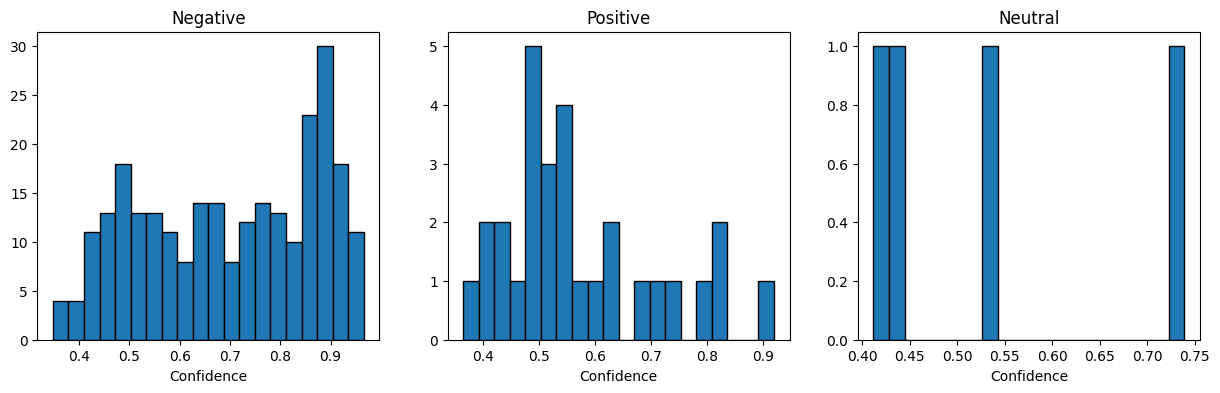

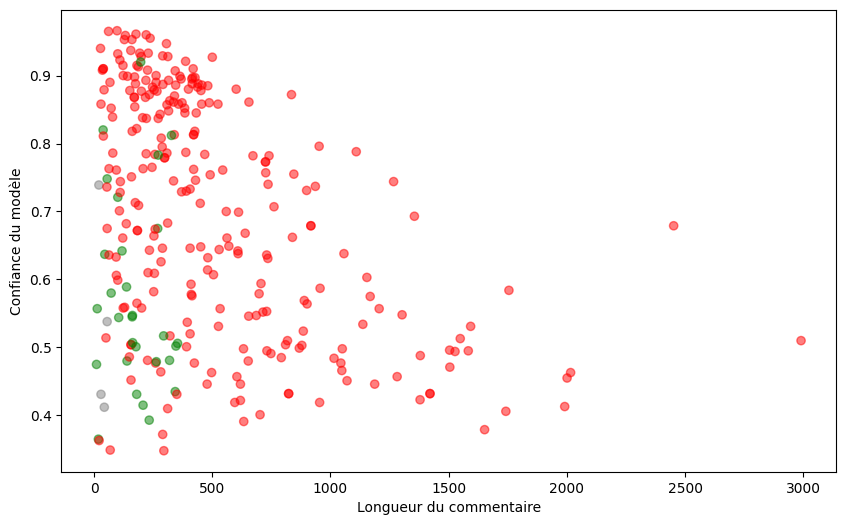

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution confiance par sentiment
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, sentiment in enumerate(['negative', 'positive', 'neutral']):
    confs = [c['confidence'] for c in results if c['sentiment'] == sentiment]
    axes[i].hist(confs, bins=20, edgecolor='black')
    axes[i].set_title(f'{sentiment.capitalize()}')
    axes[i].set_xlabel('Confidence')

# 2. Nuage de points confiance vs longueur
lengths = [len(c['content']) for c in results]
confidences = [c['confidence'] for c in results]
colors = ['red' if c['sentiment']=='negative' else 'green' if c['sentiment']=='positive' else 'gray' for c in results]

plt.figure(figsize=(10, 6))
plt.scatter(lengths, confidences, c=colors, alpha=0.5)
plt.xlabel('Longueur du commentaire')
plt.ylabel('Confiance du modèle')

In [6]:
# Alignement sentiment article/commentaires
alignment = sum(1 for c in results if c['sentiment'] == post_info['sentiment']) / len(results)

print(f"Article: {post_info['sentiment']} ({post_info['confidence']:.3f})")
print(f"Alignement avec commentaires: {alignment*100:.1f}%")

Article: negative (0.409)
Alignement avec commentaires: 88.8%
